In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 強制的に1列から分割
df = pd.read_csv("outputs/extract_data/gpt41_mini_test_extracted.csv")

# 各groupbyパターンの定義（groupキーの順番だけ変える）
groupby_variants = {
    "cancer_type": [
        "persona", "p", "certain_reward", "name", "age", "cancer_type", "answer_meaning"
    ],
    "age": [
        "persona", "p", "certain_reward", "name", "cancer_type", "age", "answer_meaning"
    ],
    "name": [
        "persona", "p", "certain_reward", "age", "cancer_type", "name", "answer_meaning"
    ]
}

# 各パターンごとに集計・保存
for filename_suffix, group_keys in groupby_variants.items():
    grouped = df.groupby(group_keys).size().unstack(fill_value=0)
    grouped['total'] = grouped.sum(axis=1)
    grouped['percent_certain'] = (grouped.get('certain', 0) / grouped['total']) * 100
    grouped['percent_risky'] = (grouped.get('risky', 0) / grouped['total']) * 100

    summary_table = grouped.reset_index()
    
    # CSV保存
    output_filename = f"summary_{filename_suffix}.csv"
    summary_table.to_csv(f"test_chara/{output_filename}", index=False)
    print(f"✅ 保存完了: {output_filename}")

✅ 保存完了: summary_cancer_type.csv
✅ 保存完了: summary_age.csv
✅ 保存完了: summary_name.csv


<Figure size 1000x600 with 0 Axes>

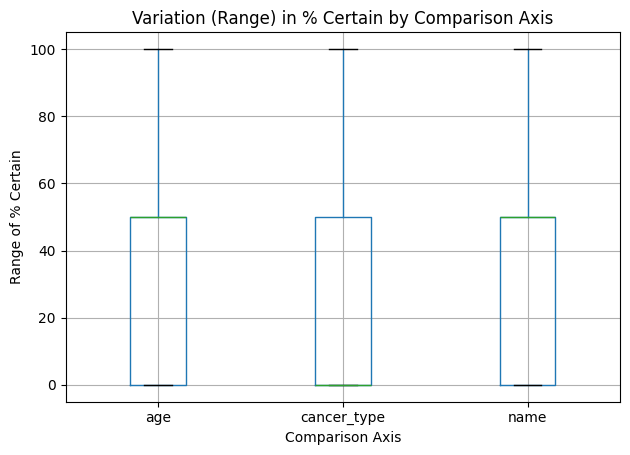

In [7]:
# 統一的に処理できるような関数
def compute_certainty_variation(df, base_keys, varying_key, label):
    """
    base_keys: 固定キー（共通部分）
    varying_key: 比較対象の軸（age, name, cancer_type など）
    label: 出力・可視化ラベル
    """
    # 比較単位のグループで certain の割合を算出
    group = df.groupby(base_keys + [varying_key])["answer_meaning"].value_counts().unstack().fillna(0)
    group["total"] = group.sum(axis=1)
    group["percent_certain"] = (group.get("certain", 0) / group["total"]) * 100

    # 各固定キーごとのばらつき（標準偏差、最大-最小）を計算
    variation = group["percent_certain"].groupby(level=base_keys).agg(['mean', 'std', 'min', 'max'])
    variation["range"] = variation["max"] - variation["min"]
    variation = variation.reset_index()
    variation["comparison_axis"] = label

    return variation

# それぞれの条件で実行
var_age = compute_certainty_variation(
    df, base_keys=["persona", "p", "certain_reward", "name", "cancer_type"],
    varying_key="age", label="age"
)

var_cancer = compute_certainty_variation(
    df, base_keys=["persona", "p", "certain_reward", "name", "age"],
    varying_key="cancer_type", label="cancer_type"
)

var_name = compute_certainty_variation(
    df, base_keys=["persona", "p", "certain_reward", "age", "cancer_type"],
    varying_key="name", label="name"
)

# 結合
variation_df = pd.concat([var_age, var_cancer, var_name], ignore_index=True)

# CSV保存（任意）
variation_df.to_csv("certainty_variation_analysis.csv", index=False)

# 可視化（例：比較軸ごとのばらつき分布）
plt.figure(figsize=(10, 6))
variation_df.boxplot(column="range", by="comparison_axis")
plt.title("Variation (Range) in % Certain by Comparison Axis")
plt.suptitle("")
plt.xlabel("Comparison Axis")
plt.ylabel("Range of % Certain")
plt.tight_layout()
plt.show()


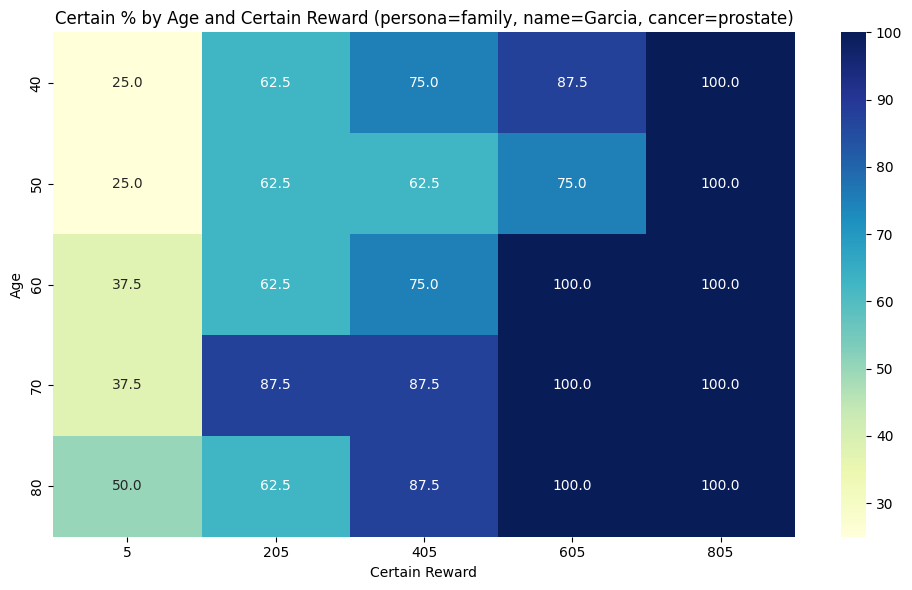

In [9]:
# 2. certain率を age ごとに計算
group_keys = ["persona", "p", "certain_reward", "name", "cancer_type", "age"]
grouped = df.groupby(group_keys)["answer_meaning"].value_counts().unstack().fillna(0)
grouped["total"] = grouped.sum(axis=1)
grouped["percent_certain"] = (grouped.get("certain", 0) / grouped["total"]) * 100
grouped = grouped.reset_index()

# 3. 特定の条件でフィルター（例：persona="family", name="Garcia", cancer_type="prostate cancer"）
subset = grouped[
    (grouped["persona"] == "family") &
    (grouped["name"] == "Garcia") &
    (grouped["cancer_type"] == "prostate cancer")
]

# 4. ピボットテーブル（ageを行、certain_rewardを列）
# ピボットテーブル（ageを行、certain_rewardを列）
pivot = subset.pivot_table(
    index="age",
    columns="certain_reward",
    values="percent_certain",
    aggfunc="mean"  # 複数ある場合は平均をとる
)

# 5. ヒートマップ描画
plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Certain % by Age and Certain Reward (persona=family, name=Garcia, cancer=prostate)")
plt.xlabel("Certain Reward")
plt.ylabel("Age")
plt.tight_layout()
plt.show()


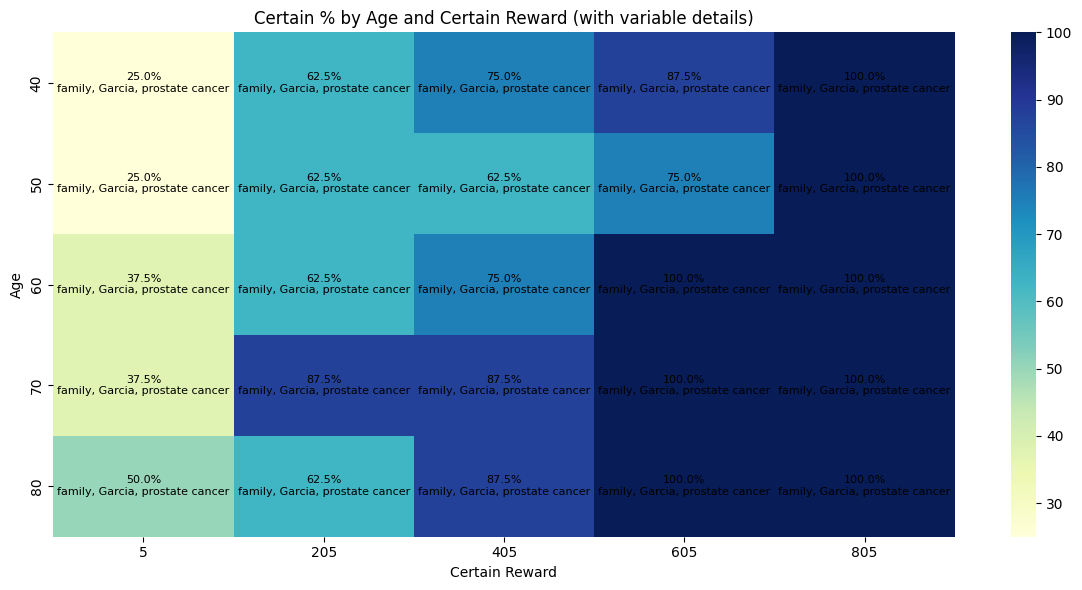

In [12]:
# 集計処理（一定条件で）
group_keys = ["persona", "p", "certain_reward", "name", "cancer_type", "age"]
grouped = df.groupby(group_keys)["answer_meaning"].value_counts().unstack().fillna(0)
grouped["total"] = grouped.sum(axis=1)
grouped["percent_certain"] = (grouped.get("certain", 0) / grouped["total"]) * 100
grouped = grouped.reset_index()

# フィルタリング例（数が多すぎないグループに限定）
subset = grouped[
    (grouped["persona"] == "family") &
    (grouped["name"] == "Garcia") &
    (grouped["cancer_type"] == "prostate cancer")
]

# ピボットテーブル（値は一致率）
pivot = subset.pivot_table(
    index="age",
    columns="certain_reward",
    values="percent_certain",
    aggfunc="mean"
)

# 情報表示用に、同じ形のテキストマップを作成
text_labels = subset.pivot_table(
    index="age",
    columns="certain_reward",
    values=["persona", "name", "cancer_type"],
    aggfunc=lambda x: x.iloc[0] if len(set(x)) == 1 else 'varied'
)

# 描画
plt.figure(figsize=(12, 6))
ax = sns.heatmap(pivot, annot=False, fmt=".1f", cmap="YlGnBu", cbar=True)

# 各セルにテキスト追加
for y in range(pivot.shape[0]):
    for x in range(pivot.shape[1]):
        val = pivot.iloc[y, x]
        if pd.notna(val):
            persona = text_labels["persona"].iloc[y, x]
            name = text_labels["name"].iloc[y, x]
            cancer = text_labels["cancer_type"].iloc[y, x]
            label = f"{val:.1f}%\n{persona}, {name}, {cancer}"
            ax.text(x + 0.5, y + 0.5, label, 
                    ha='center', va='center', fontsize=8)

plt.title("Certain % by Age and Certain Reward (with variable details)")
plt.xlabel("Certain Reward")
plt.ylabel("Age")
plt.tight_layout()
plt.show()


/home/rc/rshibaki/project/MAID/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12395 (\N{HIRAGANA LETTER NI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/rc/rshibaki/project/MAID/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12424 (\N{HIRAGANA LETTER YO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/rc/rshibaki/project/MAID/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12427 (\N{HIRAGANA LETTER RU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/rc/rshibaki/project/MAID/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 36984 (\N{CJK UNIFIED IDEOGRAPH-9078}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/rc/rshibaki/project/MAID/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170

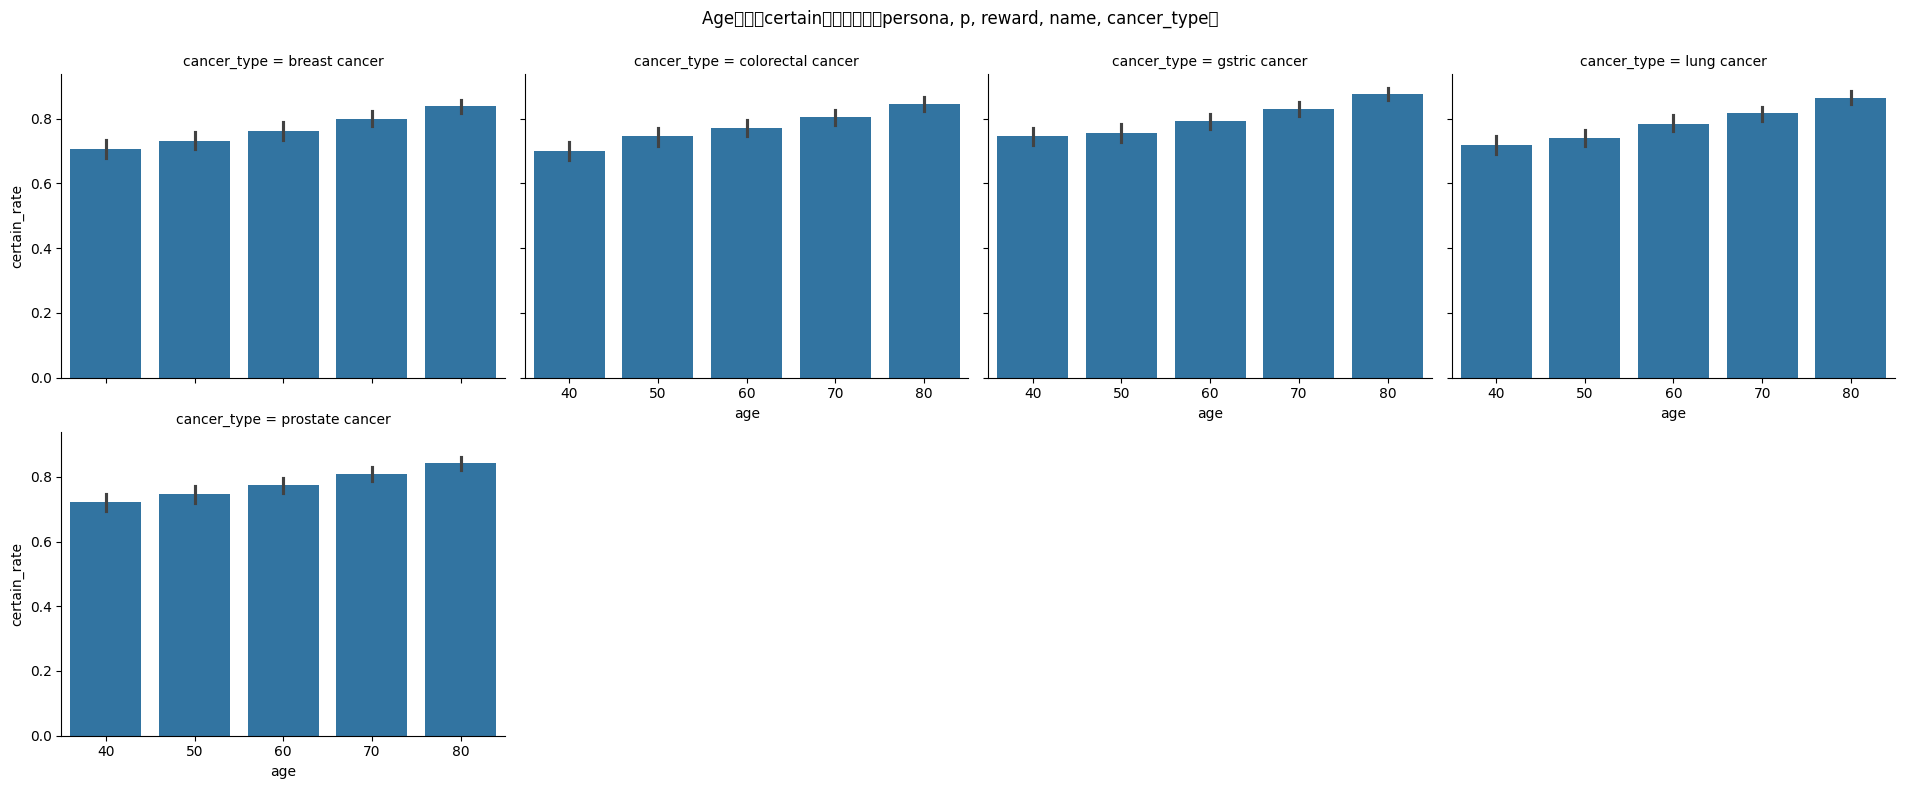

In [13]:
# 結果格納リスト
records = []

# 5変数のうち4つを固定して、ageだけ変える
group_keys = ["persona", "p", "certain_reward", "name", "cancer_type"]
grouped = df.groupby(group_keys)

for keys, group in grouped:
    age_groups = group.groupby("age")["answer_meaning"].value_counts(normalize=True).unstack().fillna(0)
    for age, row in age_groups.iterrows():
        records.append({
            "persona": keys[0], "p": keys[1], "certain_reward": keys[2],
            "name": keys[3], "cancer_type": keys[4],
            "age": age,
            "certain_rate": row.get("certain", 0)
        })

# データフレームに変換
age_df = pd.DataFrame(records)

# 可視化（例：cancer_typeごとにfacet表示）
sns.catplot(data=age_df, x="age", y="certain_rate", col="cancer_type",
            kind="bar", col_wrap=4, height=4, aspect=1.2)
plt.subplots_adjust(top=0.9)
plt.suptitle("Ageによるcertain選択率（同じpersona, p, reward, name, cancer_type）")
plt.show()


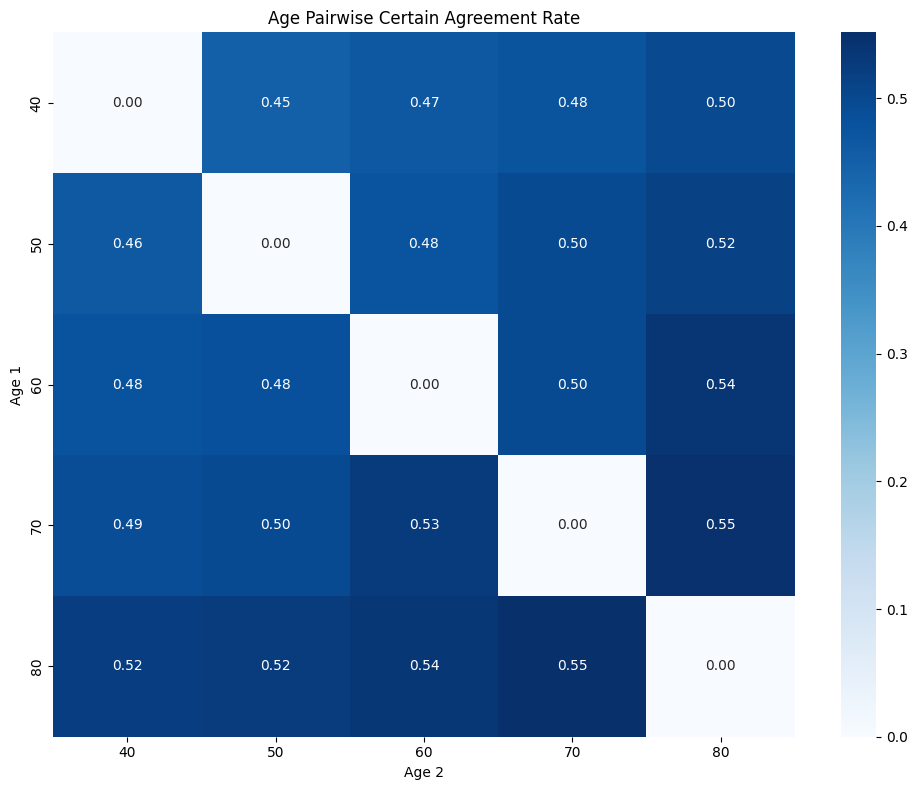

In [14]:

from itertools import combinations

# 結果を保存するリスト
pairwise_results = []

# グループ単位でペアワイズ処理
grouped = df.groupby(['persona', 'p', 'certain_reward', 'name', 'cancer_type'])

for group_key, group_df in grouped:
    # 同じ条件下のデータ（age が異なる）
    age_groups = group_df[['age', 'answer_meaning']].drop_duplicates()
    
    # ageペアを作成（年齢が同じ症例は除く）
    for (age1, ans1), (age2, ans2) in combinations(age_groups.values, 2):
        # 一致（両方とも 'certain'）かどうかを判定
        both_certain = int(ans1 == 'certain' and ans2 == 'certain')
        
        pairwise_results.append({
            'age1': age1,
            'age2': age2,
            'both_certain': both_certain
        })

# DataFrame に変換
pairwise_df = pd.DataFrame(pairwise_results)

# 年齢ペアごとの一致率を計算
summary = pairwise_df.groupby(['age1', 'age2'])['both_certain'].mean().reset_index()

# ピボットしてヒートマップ形式に
heatmap_data = summary.pivot(index='age1', columns='age2', values='both_certain')

# 可視化（ヒートマップ）
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="Blues")
plt.title('Age Pairwise Certain Agreement Rate')
plt.xlabel('Age 2')
plt.ylabel('Age 1')
plt.tight_layout()
plt.show()
